# Обучение с подкреплением

## Библиоттеки

In [1]:
from abc import abstractmethod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Байесовские однорукие бандиты

Простейшая задача --- бандиты с распределением Бернулли.
Бандиты это окружение с $K$ действиями. Действие приводит к вознаграждению $r=1$ с вероятностью $0 \le \theta_k \le 1$, неизвестной агенту, но фиксированной во времени. Цель агента - минимизировать неоптимальность на фиксированном горизонте из $T$ действий:
$$\rho = T\theta^* - \sum_{t=1}^T r_t,  \qquad \theta^* = \max_k\{\theta_k\}.$$

### Определим исследователя среды

In [2]:
class AbstractAgent:   
    def __init__(self, n_actions, seed=42):
        self.rs = np.random.RandomState(seed)

        self._successes = np.ones(n_actions)
        self._failures = np.ones(n_actions)
        self._total_pulls = 0
        
    def update(self, action, reward):
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @abstractmethod
    def get_action(self):
        pass

    @property
    def name(self):
        return self.__class__.__name__

    @property
    def total(self):
        return self._total_pulls

    @property
    def success(self):
        return self._successes

    @property
    def failure(self):
        return self._failures

#### Default агент

In [3]:
class DefaultAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(
                self.success/(self.success + self.failure))

#### Epsilon-greedy агент

In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, K, seed=42, epsilon=0.01):
        super().__init__(K, seed)
        self._epsilon = epsilon

    def get_action(self):
        if self.rs.rand() < self._epsilon:
            return self.rs.randint(0, self.success.shape[0])
        else:
            return np.argmax(self.success/(self.success + self.failure))

#### UCB агент

In [5]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        if self.total != 0:
            return np.argmax(
                self.success/(self.success + self.failure) \
                + np.sqrt(2*np.log(self.total)/(self.success + self.failure)))
        else:
            return np.argmax(
                self.success/(self.success + self.failure))

#### Thompson sampling

In [6]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        return np.argmax(self.rs.beta(self.success, self.failure))

### Стационарный бандит

In [7]:
class BernoulliBandit:
    def __init__(self, K=5, seed=42):
        self.rs = np.random.RandomState(seed)
        self._probas = self.rs.random(K)

    @property
    def action_count(self):
        return len(self._probas)

    def pull(self, action):
        return self.rs.choice([0, 1], p=[1-self._probas[action], self._probas[action]])

    def optimal_reward(self):
        return np.max(self._probas)

    def step(self):
        pass

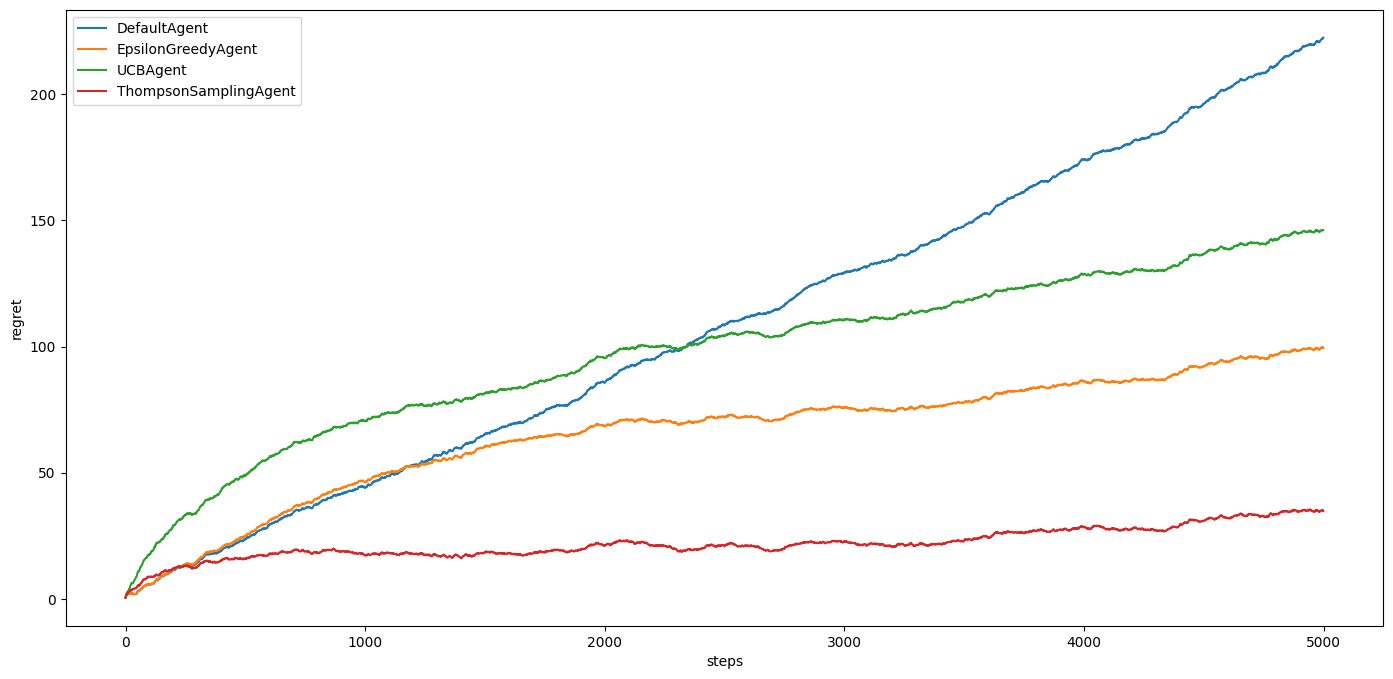

In [8]:
agents = [
    DefaultAgent,
    EpsilonGreedyAgent,
    UCBAgent,
    ThompsonSamplingAgent
]
n_steps  = 5000
n_trials = 10
K        = 5

scores = {
    agent(K).name : [0.0 for step in range(n_steps)] for agent in agents
}

for trial in range(n_trials):
    for agent in agents:
        bandit = BernoulliBandit(K, seed=trial)
        a = agent(K, seed=trial)

        for i in range(n_steps):
            optimal_reward = bandit.optimal_reward()

            action = a.get_action()
            reward = bandit.pull(action)
            a.update(action, reward)

            scores[a.name][i] += optimal_reward - reward
                
            bandit.step()

plt.figure(figsize=(17, 8))
for agent in agents:
    plt.plot(np.cumsum(scores[agent(K).name]) / n_trials, label=agent(K).name)

plt.legend(loc='best')

plt.ylabel("regret")
plt.xlabel("steps")

plt.show()

### Нестационарный бандит

In [9]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, K=5, seed=42, gamma=0.01):
        super().__init__(K, seed)
        
        self._gamma = gamma
        
        self._successes = np.ones(self.action_count)
        self._failures = np.ones(self.action_count)
        self._steps = 0
    
    def step(self):
        action = self.rs.randint(self.action_count)
        reward = self.pull(action)

        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probas = self.rs.beta(self._successes, self._failures)

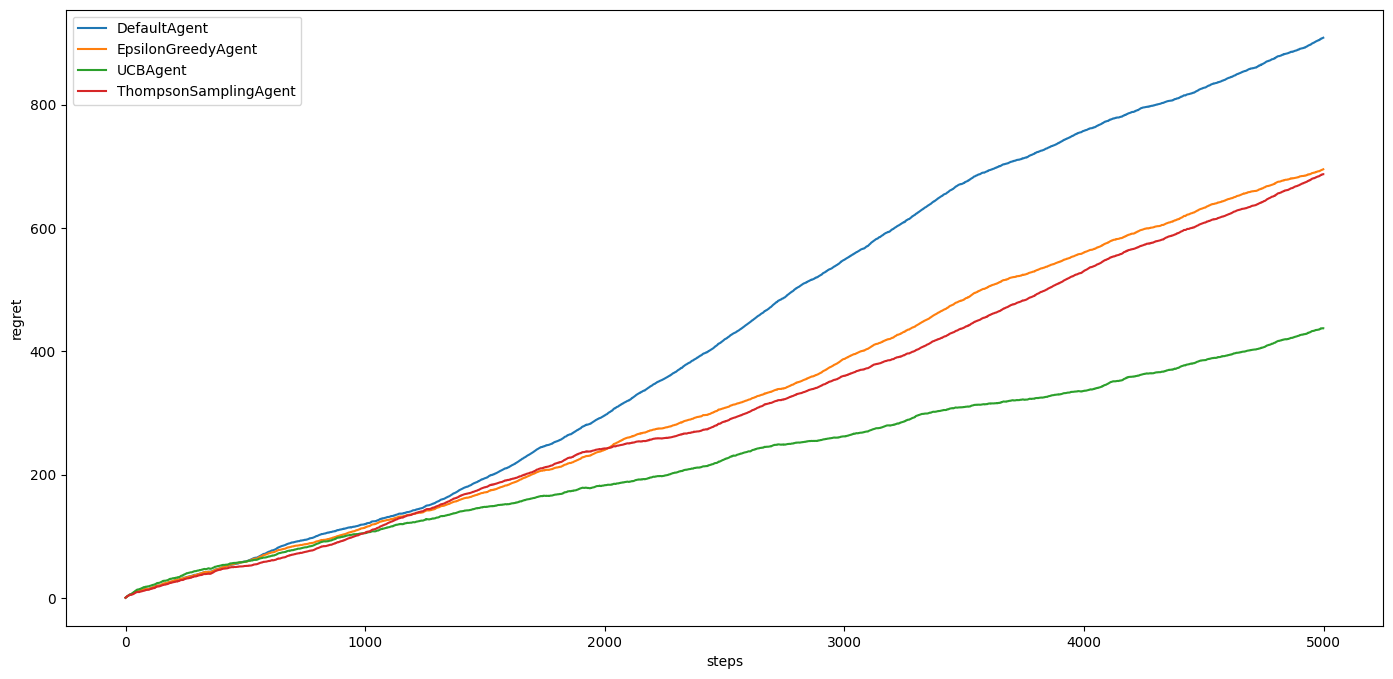

In [10]:
agents = [
    DefaultAgent,
    EpsilonGreedyAgent,
    UCBAgent,
    ThompsonSamplingAgent
]
n_steps  = 5000
n_trials = 10
K        = 5

scores = {
    agent(K).name : [0.0 for step in range(n_steps)] for agent in agents
}

for trial in range(n_trials):
    for agent in agents:
        bandit = DriftingBandit(K, seed=trial)
        a = agent(K, seed=trial)

        for i in range(n_steps):
            optimal_reward = bandit.optimal_reward()

            action = a.get_action()
            reward = bandit.pull(action)
            a.update(action, reward)
            scores[a.name][i] += optimal_reward - reward
                
            bandit.step()

plt.figure(figsize=(17, 8))
for agent in agents:
    plt.plot(np.cumsum(scores[agent(K).name]) / n_trials, label=agent(K).name)

plt.legend(loc='best')

plt.ylabel("regret")
plt.xlabel("steps")

plt.show()

#### Агент учитывающий нестационарность

In [11]:
class BrakeMemoryAgent(AbstractAgent):
    def get_action(self):
        if self.total % 700 == 0:
            self._successes=self._successes*0+1
            self._failures=self._failures*0+1
        return np.argmax(self.rs.beta(self._successes, self._failures))

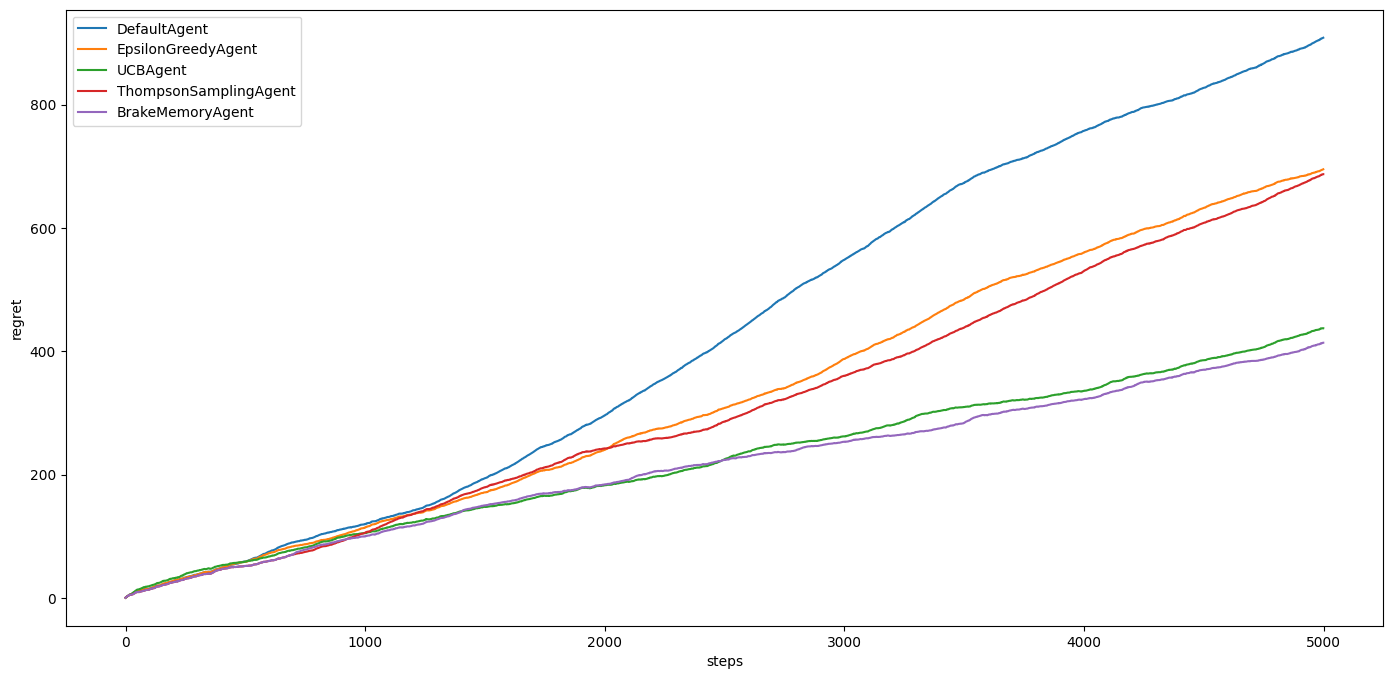

In [12]:
agents = [
    DefaultAgent,
    EpsilonGreedyAgent,
    UCBAgent,
    ThompsonSamplingAgent,
    BrakeMemoryAgent
]
n_steps  = 5000
n_trials = 10
K        = 5

scores = {
    agent(K).name : [0.0 for step in range(n_steps)] for agent in agents
}

for trial in range(n_trials):
    for agent in agents:
        bandit = DriftingBandit(K, seed=trial)
        a = agent(K, seed=trial)

        for i in range(n_steps):
            optimal_reward = bandit.optimal_reward()

            action = a.get_action()
            reward = bandit.pull(action)
            a.update(action, reward)
            scores[a.name][i] += optimal_reward - reward
                
            bandit.step()

plt.figure(figsize=(17, 8))
for agent in agents:
    plt.plot(np.cumsum(scores[agent(K).name]) / n_trials, label=agent(K).name)

plt.legend(loc='best')
plt.ylabel("regret")
plt.xlabel("steps")

plt.show()

## Задача о заплыве

Задача на основе марковских процесов.

https://arxiv.org/pdf/1306.0940.pdf

In [13]:
class RiverSwim:
    def __init__(self, 
                 isc  = 4, # число состояний (без учета крайних)
                 ms   = 16, # максимальное число шагов
                 lr   = 5/1000, 
                 rr   = 1.0, 
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False

In [14]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


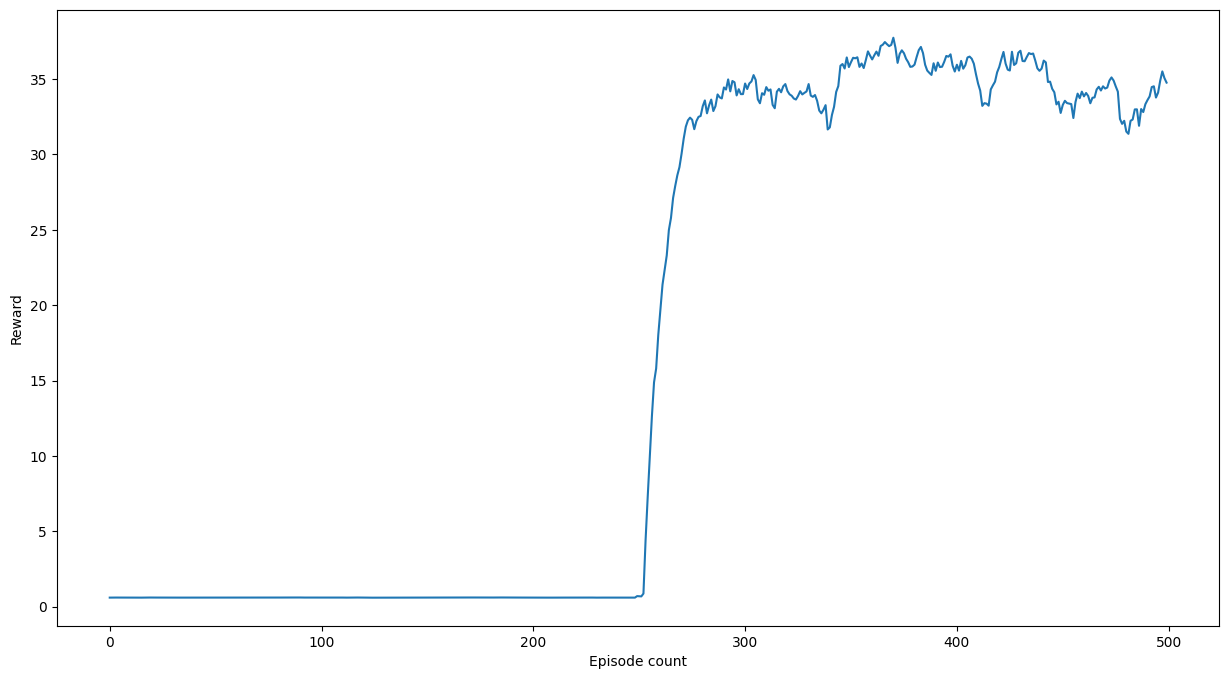

In [15]:
n = 2
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        
        state = next_state
        ep_reward += reward
        
    episode_rewards.append(ep_reward)

plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

<ipython-input-16-3c99130bf45b>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


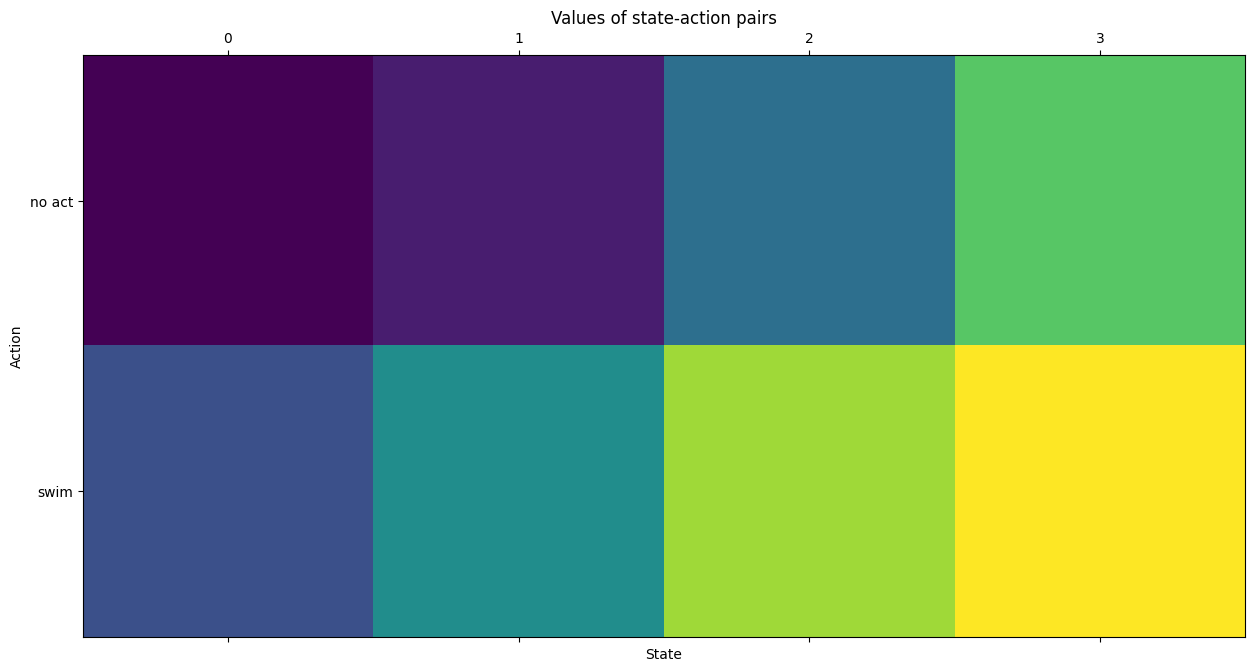

In [16]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()